# Building Query Pattern Classifiers for RAG Systems

> Pre-requisites: Make sure you've completed the "1. Cluster Conversations" and "2. Better Summaries" notebooks to understand the underlying data and topic modeling results. You'll need the instructor and instructor_classify libraries installed, along with the labeled dataset we created from our clustering analysis.

## Why This Matters

After using topic modeling to identify patterns in user queries, the next step is creating a reliable classifier that can automatically categorize new queries as they arrive. While topic modeling helps with discovery, a well-trained classifier allows you to:

1. Monitor query patterns in real-time - Track which categories of questions users are asking most frequently
2. Detect emerging issues - Identify when certain query types suddenly increase in volume
3. Route queries appropriately - Direct questions to specialized retrieval pipelines or tools based on their category


More importantly, by identifying and tracking query volumes, we can systematically prioritise areas for improvement. If we identify categories of queries which have high user satisfaction with low volume or queries which have low user satisfaction with high volume, these are immediate areas fof concern and prioritisation. 

## What You'll Learn

In this notebook, you'll discover how to:

1. Define Query Categories Based on Topic Insights
- Convert topic clusters into explicit classification categories
- Structure these categories for effective prompting
- Create a system that domain experts can easily update


2. Build an LLM-based Classifier with Instructor
- Implement a classifier using the instructor-classify framework
- Test different prompting strategies to improve accuracy
- Evaluate performance against labeled examples


3. Measure and Improve Classification Accuracy
- Create a labeled dataset for evaluation
- Use confusion matrices to identify classification errors
- Iteratively improve the classifier

## Defining Our Classifier

Our topic modeling revealed several distinct clusters of user queries, with three major topics accounting for the majority of questions:

1. Users seeking help with experiment tracking and metrics logging
2. Users trying to manage artifacts and data versioning
3. Users needing assistance with integrations and deployment

In this notebook, we'll show how we might build a classifier which can identify queries related to creating, managing and versioning weights and biases artifacts. Let's define this using a binary classifier using `instructor-classify`

In [76]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and documen pair which is about creating, versioning and managing weights and biases artifacts."
)

not_artefact_label = LabelDefinition(
    label="not_artifact",
    description="This is a user query and documen pair which does not contain any information or mention about creating, versioning and managing weights and biases artifacts."
)

classification_def = ClassificationDefinition(
    system_message="You're an expert at classifying user queries and documents as related to creating, versioning and managing weights and biases artifacts.",
    label_definitions=[artifact_label, not_artefact_label]
)


This structure makes it easy to define multiple categories in a way that's clear to both humans and LLMs. It provides explicit definitions of what each category means, making it easier for the model to make accurate predictions.

Later in this notebook, we'll see how we can export this to a yaml format for easy versioning with `git`

### A Simple Example

Let's now see how `instructor-classify` works under the hood. We'll do so by passing in 4 sample queries and seeing how our classifier is able to deal with these test cases

In [77]:
import instructor
from instructor_classify.classify import Classifier
from openai import OpenAI

client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def)
    .with_client(client)
    .with_model("gpt-4.1-mini")
)

# Make a prediction
result = classifier.predict("How do I version a weights and biases artifact?")
print(f"Classification: {result.label}")  # Should output "artifact";

result_2 = classifier.predict("What is the square root of 9?")
print(f"Classification: {result_2.label}")  # Should output "not_artifact"

Classification: artifact
Classification: not_artifact


`instructor-classify` exposes a `batch_predict` function which parallelises this operation for us so that we can run evaluations efficiently over large datasets. Let's see it in action below with some test cases


In [81]:
tests = [
    "How do I version a weights and biases artifact?",
    "What is the square root of 9?",
    "How do I integrate weights and biases with pytorch?",
    "How do I deploy weights and biases in my own infrastructure?"
]

labels = [
    "artifact",
    "not_artifact",
    "not_artifact",
    "not_artifact",
]

results = classifier.batch_predict(tests)
for query, result, label in zip(tests, results, labels):
    print(f"Query: {query}\nClassification: {result.label}\nExpected: {label}\n")


classify:   0%|          | 0/4 [00:00<?, ?it/s]

Query: How do I version a weights and biases artifact?
Classification: artifact
Expected: artifact

Query: What is the square root of 9?
Classification: not_artifact
Expected: not_artifact

Query: How do I integrate weights and biases with pytorch?
Classification: artifact
Expected: not_artifact

Query: How do I deploy weights and biases in my own infrastructure?
Classification: not_artifact
Expected: not_artifact



We can see that our classifier performs pretty well here, with an accuracy of 75%. It wrongly classifies `How do I integrate weights and biases with Pytorch as an artifact query` when this instead is a query which deals with integration related issues in Weights and Biases.

## Evaluating Our Classifier

We've labelled a dataset of ~100 items our of our 560 conversations ahead of time. If you'd like to label more datasets, we've provided an `app.py` file which you can run using the command `streamlit run app.py`.

We'll be splitting this into a test and validation split. We'll be using the `validation` split to iterate on our prompt and experiment with different few shot examples before using the `test` split to validate our classifier's performance. 

We'll be using a 70-30 split with 70% of our data used for validation and 30% used for testing our final classifier. 

In [110]:
import json
import random

with open("./data/labels.jsonl") as f:
    data = [json.loads(line) for line in f]

# Set random seed for reproducibility
random.seed(42)

# Shuffle the data
random.shuffle(data)

# Calculate split index
split_idx = int(len(data) * 0.7)

# Split into validation and test sets
val_set = data[:split_idx]
test_set = data[split_idx:]

print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Validation set size: 81
Test set size: 36


### Determining a baseline

Let's now calculate a baseline and see how well our initial classification model performs.

In [111]:
val_text = [
    f"Query: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in val_set
]
val_labels = [item['label'] for item in val_set]

test_text = [
    f"Query: {item['query']}\n Retrieved Document: {item['matching_document']}"
    for item in test_set
]
test_labels = [item['label'] for item in test_set]

Let's now define a function which runs the classifier on the validation set and the test set to see our initial starting point. We'll look at some of the failure cases and then iterately improve our classifier.

In [112]:
from sklearn.metrics import confusion_matrix

def predict_and_evaluate(texts, labels):
    classifier = Classifier(classification_def).with_client(instructor.from_provider("openai/gpt-4.1-mini")).with_model("gpt-4.1-mini")
    predictions = classifier.batch_predict(texts)
    return {
        "accuracy": sum(pred.label == label for pred, label in zip(predictions, labels)) / len(predictions),    
        "confusion_matrix": confusion_matrix(labels, [p.label for p in predictions], labels=['artifact', 'not_artifact']),
        "queries": texts,
        "labels": labels,
        "predictions": [p.label for p in predictions]
    }

predictions = predict_and_evaluate(val_text, val_labels)
predictions["accuracy"]

0.6419753086419753

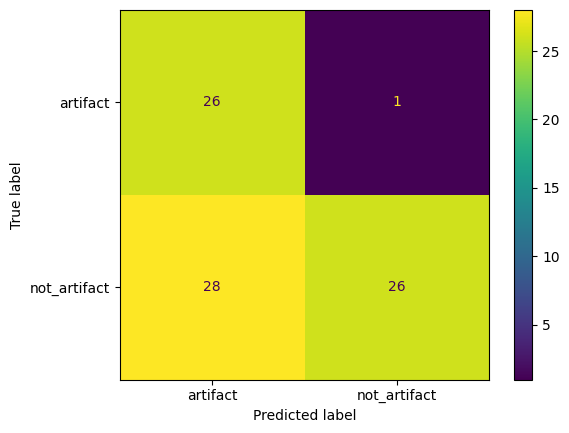

In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=predictions["confusion_matrix"], 
                             display_labels=['artifact', 'not_artifact'])
disp.plot()
plt.show()

Let's now see how it looks like when we run it on our test set

In [114]:
test_predictions = predict_and_evaluate(test_text, test_labels)
test_predictions["accuracy"]

0.5277777777777778

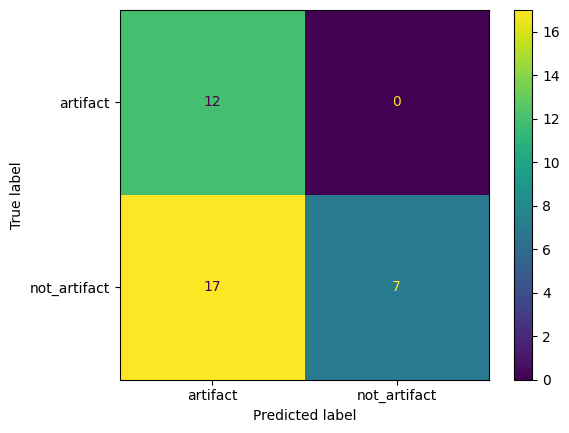

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=test_predictions["confusion_matrix"], 
                             display_labels=['artifact', 'not_artifact'])
disp.plot()
plt.show()

### Looking at Edge Cases

Let's now look at the cases where our model performed badly. We can see from our confusion matrix above that our classifier tends to classify non-artifact related queries as artifact queries. 

Let's look through some of the failed cases manually where this happens from our validation set to see if we might be ale to understand why this is happening.

In [117]:
count = 3
for query, label, pred in zip(predictions['queries'], predictions['labels'], predictions['predictions']):
    count -= 1
    if label == 'not_artifact' and pred == 'artifact':
        print("=====")
        print(f"Label: {label}")
        print(f"Prediction: {pred}")
        print(f"{query}")
        print("=====")

    if count == 3:
        break

=====
Label: not_artifact
Prediction: artifact
Query: How can LangChain be used in conjunction with Weights & Biases?
 Retrieved Document: ## Prompts Quickstart
### Use W&B Trace with LangChain
#### 1. Set the LANGCHAIN\_WANDB\_TRACING environment variable
First, set the LANGCHAIN\_WANDB\_TRACING environment variable to true. This will turn on automated Weights & Biases logging with LangChain:  

```
import os

# turn on wandb logging for langchain
os.environ["LANGCHAIN\_WANDB\_TRACING"] = "true"

```  

Thats it! Now any call to a LangChain LLM, Chain, Tool or Agent will be logged to Weights & Biases.
=====
=====
Label: not_artifact
Prediction: artifact
Query: Wandb init configuration
 Retrieved Document: ## init
| Arguments |  |
| --- | --- |
| `project` | (str, optional) The name of the project where you're sending the new run. If the project is not specified, the run is put in an "Uncategorized" project. |
| `entity` | (str, optional) An entity is a username or team name where you'

We can see here that there are a few queries here that are tripping up our classifier

1. `What are the key features of wandb` : This includes some information about Artifacts in the retrieved document but the user's query itself is not explicitly about the usage of Artifacts with Weights and Biases.

2. `Weights & Biases integration OpenAI` : This is a question about integrations, specifically about the OpenAI integration with WandDB and the user's query is not related to the storage, usage or management of artifacts at all

Let's see how we can improve on `instructor-classify` by leveraging few shot examples and a better system prompt

## Improving Our Classifier

Now that we've identified these cases, we can do two main things to improve our classifier. 

The first thing is to supply a better system prompt. Specifically we'll tell our model to look closely at the user query to determine if the user has an initial query about manging and versioning artifacts.

In [119]:
from instructor_classify.schema import LabelDefinition, ClassificationDefinition

artifact_label = LabelDefinition(
    label="artifact",
    description="This is a user query and document pair which has a user query that is about creating, versioning and managing weights and biases artifacts."
)

not_artefact_label = LabelDefinition(
    label="not_artifact",
    description="This is a user query and document pair which does not have a user query that is about creating, versioning and managing weights and biases artifacts."
)

classification_def = ClassificationDefinition(
    system_message="""
You're an expert at classifying user queries and documents as related to creating, versioning and managing weights and biases artifacts.

You'll be given a user query and a retrieved matching document. Your job is to classify the user query as either an artifact query or not an artifact query.

Your job is to look closely at the user query and the retrieved document to determine if the user's query is about creating, versioning and managing weights and biases artifacts. This does not include queries about integrations with other libraries/providers unless the user is explicitly asking about how to manage the artifacts from these integrations.
""",
    label_definitions=[artifact_label, not_artefact_label]
)


In [120]:
client = instructor.from_openai(OpenAI())
classifier = (
    Classifier(classification_def)
    .with_client(client)
    .with_model("gpt-4.1-mini")
)

In [122]:
def predict_and_evaluate(classifier, texts, labels):
    predictions = classifier.batch_predict(texts)
    return {
        "accuracy": sum(pred.label == label for pred, label in zip(predictions, labels)) / len(predictions),    
        "confusion_matrix": confusion_matrix(labels, [p.label for p in predictions], labels=['artifact', 'not_artifact']),
        "queries": texts,
        "labels": labels,
        "predictions": [p.label for p in predictions]
    }

predictions = predict_and_evaluate(classifier, val_text, val_labels)
predictions["accuracy"]

0.9506172839506173

Let's now see how our model performs by using a confusion matrix

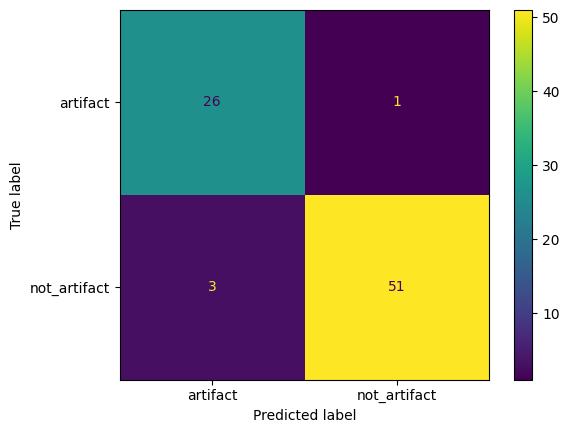

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=predictions["confusion_matrix"], 
                             display_labels=['artifact', 'not_artifact'])
disp.plot()
plt.show()

Let's now examine our last 4 failure cases and see if we can get aroud this

In [124]:
count = 3
for query, label, pred in zip(predictions['queries'], predictions['labels'], predictions['predictions']):
    count -= 1
    if label != pred:
        print("=====")
        print(f"Label: {label}")
        print(f"Prediction: {pred}")
        print(f"{query}")
        print("=====")

    if count == 3:
        break

=====
Label: not_artifact
Prediction: artifact
Query: wandb.Table documentation
 Retrieved Document: ## Table

View source on GitHub  

The Table class used to display and analyze tabular data.  

```
Table(
columns=None, data=None, rows=None, dataframe=None, dtype=None, optional=(True),
allow\_mixed\_types=(False)
)

```  

Unlike traditional spreadsheets, Tables support numerous types of data:
scalar values, strings, numpy arrays, and most subclasses of `wandb.data_types.Media`.
This means you can embed `Images`, `Video`, `Audio`, and other sorts of rich, annotated media
directly in Tables, alongside other traditional scalar values.  

This class is the primary class used to generate the Table Visualizer
in the UI: <https://docs.wandb.ai/guides/data-vis/tables>.  

Tables can be constructed with initial data using the `data` or
`dataframe` parameters:
=====
=====
Label: not_artifact
Prediction: artifact
Query: Integrating Weights & Biases with Hugging Face's Accelerate
 Retrieved Doc

## Conclusion
In this series of notebooks, we've built a systematic workflow for improving RAG systems through query pattern analysis. Beginning with topic modeling, we identified key clusters around experiment tracking, artifact management, and integrations in Weights & Biases, giving us insight into what users are actually asking and where our system might be falling short.

We enhanced our approach by developing domain-specific summarization techniques that transformed generic descriptions into precise insights about W&B features and user intents. This led to more meaningful clusters that better reflected real user needs and created a foundation for targeted improvements.

Finally, we built a classifier to automatically categorize incoming queries, enabling ongoing monitoring and targeted interventions. This classification system now sets the stage for more advanced RAG components - specialized retrieval pipelines, metadata extraction, and function calling systems that address specific user needs effectively. By understanding query patterns systematically, we've created a data-driven foundation for continuous RAG improvement based on actual user behavior.